# Outflow bank customers

## Introduction

Customers began to leave the bank every month. Bank marketers have calculated that it is cheaper to retain current customers than to attract new ones.

It is necessary to predict whether the client will leave the bank in the near future or not. We have historical data on the behavior of customers and the termination of contracts with the bank. 

We need to build a model with an extremely large value of *F1*-measures. 

Additionally measure *AUC-ROC*, compare its value with *F1*-measure.

Data source: [https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling](https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling)


## Preprocessing data

In [ ]:
!pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.6/98.6 MB 7.1 MB/s eta 0:00:00


In [ ]:
import warnings

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import ConfusionMatrixDisplay, f1_score, roc_curve, roc_auc_score
from sklearn.utils import shuffle
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler

from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

RANDOM_STATE = 42
warnings.filterwarnings("ignore")
plt.style.use('dark_background')

In [ ]:
df = pd.read_csv('https://code.s3.yandex.net/datasets/Churn.csv')

In [ ]:
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


Get rid of useless features

In [ ]:
df = df.drop(['Surname', 'RowNumber', 'CustomerId'], axis=1)

### Check duplicates and missing value

In [ ]:
df.duplicated().sum(), df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CreditScore      10000 non-null  int64  
 1   Geography        10000 non-null  object 
 2   Gender           10000 non-null  object 
 3   Age              10000 non-null  int64  
 4   Tenure           9091 non-null   float64
 5   Balance          10000 non-null  float64
 6   NumOfProducts    10000 non-null  int64  
 7   HasCrCard        10000 non-null  int64  
 8   IsActiveMember   10000 non-null  int64  
 9   EstimatedSalary  10000 non-null  float64
 10  Exited           10000 non-null  int64  
dtypes: float64(3), int64(6), object(2)
memory usage: 859.5+ KB


(0, None)

In [ ]:
df.isna().sum()

CreditScore          0
Geography            0
Gender               0
Age                  0
Tenure             909
Balance              0
NumOfProducts        0
HasCrCard            0
IsActiveMember       0
EstimatedSalary      0
Exited               0
dtype: int64

In [ ]:
df.describe()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,10000.000000,10000.000000,9091.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,650.528800,38.921800,4.997690,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,96.653299,10.487806,2.894723,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,584.000000,32.000000,2.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


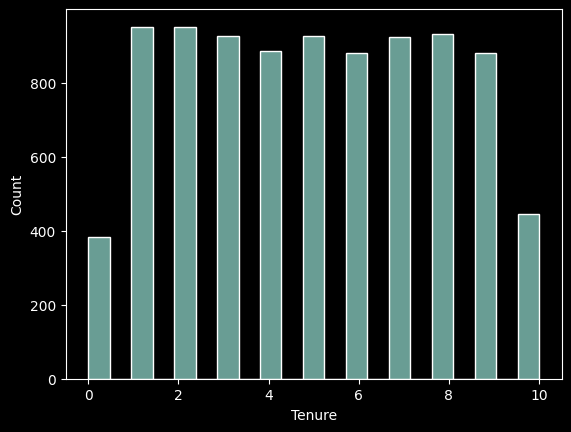

In [ ]:
sns.histplot(df['Tenure']);

We have missing values in column "Tenure", change them median with the help of SimpleImputer in Pipeline

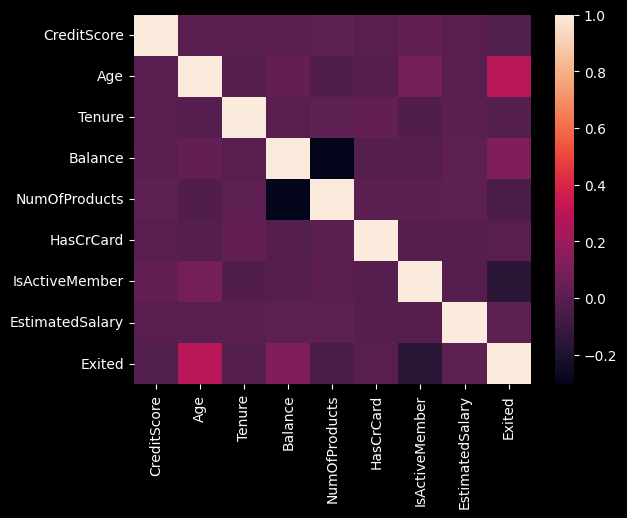

In [ ]:
sns.heatmap(df.corr());

Multicollinearity wasn't found.

### Preparing features

Split dataframe into two sample

In [ ]:
X = df.drop('Exited', axis=1)
y = df['Exited']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE)

In [ ]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((8000, 10), (2000, 10), (8000,), (2000,))

Some features such as "HasCrCard" and "IsActiveMember" are categorical binary features, so we don't need encode them.

In [ ]:
cat_features = X.select_dtypes(include='object').columns.to_list()
num_features = X.select_dtypes(exclude='object').columns.to_list()
num_features = [i for i in num_features if i not in ['HasCrCard', 'IsActiveMember']]

In [ ]:
X[num_features], X[cat_features]

(      CreditScore  Age  Tenure    Balance  NumOfProducts  EstimatedSalary
 0             619   42     2.0       0.00              1        101348.88
 1             608   41     1.0   83807.86              1        112542.58
 2             502   42     8.0  159660.80              3        113931.57
 3             699   39     1.0       0.00              2         93826.63
 4             850   43     2.0  125510.82              1         79084.10
 ...           ...  ...     ...        ...            ...              ...
 9995          771   39     5.0       0.00              2         96270.64
 9996          516   35    10.0   57369.61              1        101699.77
 9997          709   36     7.0       0.00              1         42085.58
 9998          772   42     3.0   75075.31              2         92888.52
 9999          792   28     NaN  130142.79              1         38190.78
 
 [10000 rows x 6 columns],
      Geography  Gender
 0       France  Female
 1        Spain  Female

In [ ]:
y_train.value_counts(normalize=True)

0    0.7945
1    0.2055
Name: Exited, dtype: float64

There is an imbalance of classes in the training sample. We will investigate several models and check the effect of the imbalance on the quality of prediction.

## Models Building

**Create function for searching the best model**

In [ ]:
#pipline for transforming columns
numeric_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="median")), ("scaler", StandardScaler())]
)

categorical_transformer = Pipeline(
    steps=[("encoder", OneHotEncoder(handle_unknown="ignore"))]
)
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, num_features),
        ("cat", categorical_transformer, cat_features)
    ],
    verbose_feature_names_out=False
)

In [ ]:
def clf_models(X_train, y_train, class_weight: str = None, class_weight_catboost: str = None):
  models = []
  
  #LogisticRegression
  X_train_lr = X_train.copy()
  y_train_lr = y_train.copy()

  pipline_lr = Pipeline(
      [("preprocessor", preprocessor),
      ("lr", LogisticRegression(class_weight=class_weight, random_state=RANDOM_STATE))])

  param_lr = {"lr__C":np.logspace(-5,5,11),}
  grid_lr = GridSearchCV(pipline_lr, param_grid=param_lr, scoring='f1', cv=5, n_jobs=-1)
  grid_lr.fit(X_train_lr, y_train_lr)
  best_result_lr = pd.DataFrame(grid_lr.cv_results_).sort_values('rank_test_score').head(1)
  best_result_lr = best_result_lr[['mean_fit_time', 'params', 'mean_test_score']]
  models.append(grid_lr.best_estimator_)

  #LGBMClassifier
  X_train_lgbm = X_train.copy()
  y_train_lgbm = y_train.copy()

  pipline_lgbm = Pipeline(
      [("preprocessor", preprocessor),
      ("lgbm", LGBMClassifier(class_weight=class_weight, random_state=RANDOM_STATE))])

  param_lgbm = {'lgbm__max_depth': [3, 5, 7],
          'lgbm__n_estimators': [1000, 2000, 3000]}
  grid_lgbm = GridSearchCV(pipline_lgbm, param_grid=param_lgbm, scoring='f1', cv=5, n_jobs=-1)
  grid_lgbm.fit(X_train_lgbm, y_train_lgbm)
  best_result_lgbm = pd.DataFrame(grid_lgbm.cv_results_).sort_values('rank_test_score').head(1)
  best_result_lgbm = best_result_lgbm[['mean_fit_time', 'params', 'mean_test_score']]
  models.append(grid_lgbm.best_estimator_)

  #CatBoostClassifier
  X_train_cb = X_train.copy()
  y_train_cb = y_train.copy()

  pipline_cb = Pipeline(
      [("preprocessor", preprocessor),
      ("cb", CatBoostClassifier(auto_class_weights=class_weight_catboost, random_state=RANDOM_STATE, verbose=False))])

  param_cb = {'cb__max_depth': [3, 5, 7],
          'cb__n_estimators': [1000, 2000, 3000]}
  grid_cb = GridSearchCV(pipline_cb, param_grid=param_cb, scoring='f1', cv=5, n_jobs=-1)
  grid_cb.fit(X_train_cb, y_train_cb)
  best_result_cb = pd.DataFrame(grid_cb.cv_results_).sort_values('rank_test_score').head(1)
  best_result_cb = best_result_cb[['mean_fit_time', 'params', 'mean_test_score']]
  models.append(grid_cb.best_estimator_)

  #result
  result = pd.concat([best_result_lr, best_result_lgbm, best_result_cb])
  result.index = ['LogisticRegression', 
                  'LGBMClassifier', 'CatBoostClassifier']
  display(result)
  return models

### Default sample

Training the model on the data without changes

In [ ]:
general_models = clf_models(X_train, y_train)

,mean_fit_time,params,mean_test_score
LogisticRegression,0.079522,{'lr__C': 10.0},0.190033
LGBMClassifier,2.056319,"{'lgbm__max_depth': 3, 'lgbm__n_estimators': 1...",0.544672
CatBoostClassifier,23.808594,"{'cb__max_depth': 5, 'cb__n_estimators': 3000}",0.562249


According training results we can see that the best result of metric f1 isn't higher then 0.57. Let's try conducting work with imbalance.

## Solving imbalanced classes

### Oversampling

In [ ]:
ros = RandomOverSampler(random_state=RANDOM_STATE)
X_ros, y_ros = ros.fit_resample(X_train, y_train)

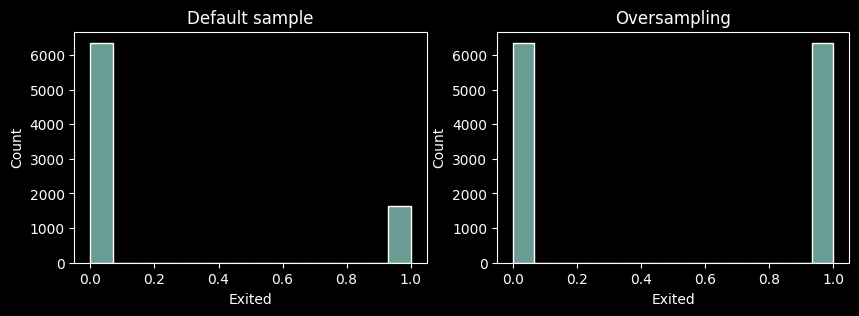

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 3))

sns.histplot(y_train,ax=ax1)
ax1.set_title('Default sample')
sns.histplot(y_ros, ax=ax2)
ax2.set_title('Oversampling');

Oversampling was done. Let's start trainig.

In [ ]:
models_ros = clf_models(X_ros, y_ros)

,mean_fit_time,params,mean_test_score
LogisticRegression,0.117471,{'lr__C': 0.001},0.692995
LGBMClassifier,7.556511,"{'lgbm__max_depth': 7, 'lgbm__n_estimators': 3...",0.943649
CatBoostClassifier,56.570786,"{'cb__max_depth': 7, 'cb__n_estimators': 3000}",0.889872


All the models has shown excellent results. Let's go on

### Undersampling

In [ ]:
rus = RandomUnderSampler(random_state=RANDOM_STATE)
X_rus, y_rus = rus.fit_resample(X_train, y_train)

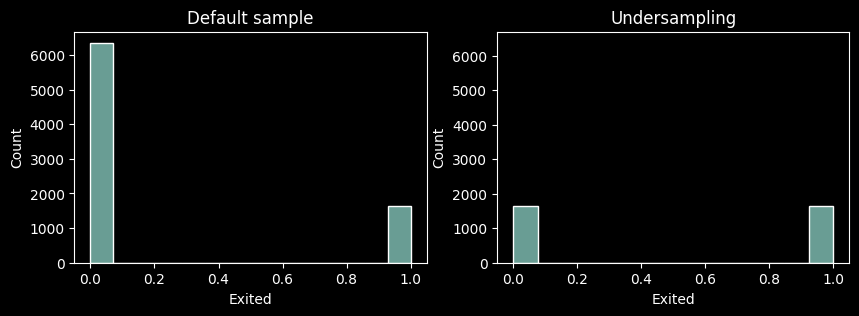

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 3))
plt.ylim(0, 6700)
sns.histplot(y_train,ax=ax1)
ax1.set_title('Default sample')
sns.histplot(y_rus, ax=ax2)
ax2.set_title('Undersampling');

In [ ]:
models_rus = clf_models(X_rus, y_rus)

,mean_fit_time,params,mean_test_score
LogisticRegression,0.031360,{'lr__C': 0.01},0.696332
LGBMClassifier,0.540200,"{'lgbm__max_depth': 3, 'lgbm__n_estimators': 1...",0.744433
CatBoostClassifier,10.019965,"{'cb__max_depth': 3, 'cb__n_estimators': 3000}",0.766455


Undersampling method looks worse, perhaps we lack volume of data.

### Weighting the classes

In [ ]:
models_class_weight = clf_models(X_train, y_train, 'balanced', 'Balanced')

,mean_fit_time,params,mean_test_score
LogisticRegression,0.044791,{'lr__C': 0.001},0.490007
LGBMClassifier,0.879450,"{'lgbm__max_depth': 3, 'lgbm__n_estimators': 1...",0.577043
CatBoostClassifier,23.187419,"{'cb__max_depth': 5, 'cb__n_estimators': 3000}",0.597790


Weighting classes method didn't show us outstanding results. Let's look on test results

## Test models

In [ ]:
default = []
oversampling = []
undersampling = []
class_weight = []

# Fuction for getting test results
def test_result(models, result_list):
  for model in models: 
    result_list.append(f1_score(y_test, model.predict(X_test)))
  return result_list

default = test_result(general_models, default)
oversampling = test_result(models_ros, oversampling)
undersampling = test_result(models_rus, undersampling)
class_weight = test_result(models_class_weight, class_weight)

test_result_df = pd.DataFrame({'Models': [type(i[1]).__name__ for i in general_models],
                               'Default': default,
                               'Oversampling': oversampling,
                               'Undersampling': undersampling,
                               'class_weight': class_weight})
test_result_df

,Models,Default,Oversampling,Undersampling,class_weight
0,LogisticRegression,0.218688,0.485915,0.495560,0.490667
1,LGBMClassifier,0.579882,0.552011,0.551527,0.564655
2,CatBoostClassifier,0.566667,0.592509,0.584555,0.586313


Let's see which features most influenced the training of the model.

In [ ]:
preprocessor.fit(X_train)
feature_importance = pd.DataFrame({'Features': preprocessor.get_feature_names_out(),
              'Importance': models_class_weight[2][1].feature_importances_}).sort_values('Importance', ascending=False)
feature_importance    

,Features,Importance
4,NumOfProducts,28.219552
1,Age,20.246607
3,Balance,14.941440
5,EstimatedSalary,10.386458
0,CreditScore,10.084156
7,Geography_Germany,5.170812
2,Tenure,5.096625
8,Geography_Spain,1.786323
6,Geography_France,1.481785
9,Gender_Female,1.376044


We can see that oversampling and undersampling gave us high variance, this indicates that the models is overfitted. The best result was got with the help CatBoostClassifier with auto_class_weight method.

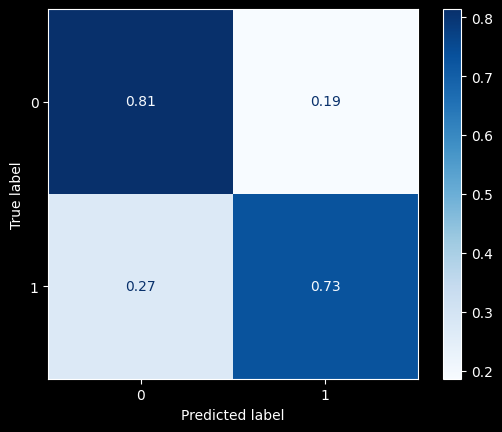

In [ ]:
ConfusionMatrixDisplay.from_estimator(models_class_weight[2], X_test, y_test, normalize='true', colorbar=True, cmap='Blues');

With the help of the confusion matrix we see that only 73% of client, who left, was detected correctly.  Check it with AUC-ROC.

### AUC-ROC of the best model

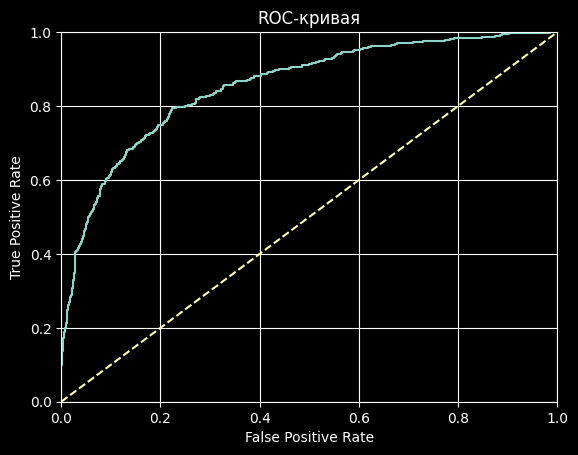

In [ ]:
probabilities_test = models_class_weight[2].predict_proba(X_test)
probabilities_one_test = probabilities_test[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, probabilities_one_test)

plt.figure()

plt.plot(fpr, tpr)

plt.plot([0, 1], [0, 1], linestyle='--')

plt.xlim([0,1])
plt.ylim([0,1])

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.grid()
plt.title("ROC-кривая")

plt.show()

In [ ]:
roc_auc_score(y_test, probabilities_one_test)

0.8547005705002446

Let's find the difference between TPR and FPR at different thresholds.

In [ ]:
df_roc = pd.DataFrame({'fpr': fpr, 'tpr':tpr, 'thresholds':thresholds})
df_roc['tpr - fpr'] = df_roc['tpr'] - df_roc['fpr']
df_roc.sort_values('tpr - fpr', ascending=False).head()

,fpr,tpr,thresholds,tpr - fpr
300,0.223398,0.793893,0.429860,0.570495
298,0.222775,0.791349,0.431067,0.568573
299,0.223398,0.791349,0.430808,0.567951
296,0.222153,0.788804,0.432896,0.566651
297,0.222775,0.788804,0.431287,0.566029


Depending on the weight of income (TPR) from customer retention and the weight of costs (TPR) in case of erroneous triggering, it is possible to determine the optimal threshold at which the profit will be maximum. We can suppose that there are weight of income and weight of costs equal in our case. So the optimal threshold will be:

In [ ]:
optimal_threshold = df_roc.sort_values('tpr - fpr', ascending=False)['thresholds'].head(1).values[0]
optimal_threshold

0.4298601356103618

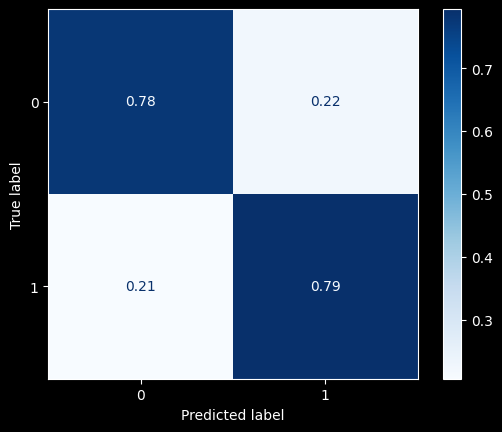

In [ ]:
ConfusionMatrixDisplay.from_predictions(y_test, probabilities_one_test >= optimal_threshold, normalize='true', colorbar=True, cmap='Blues');

## Conclusion

1.We trained three models (LogisticRegression, LGBMClassifier, CatBoostClassifier) on the original sample and balanced. Balancing was performed in three different ways: weighting classes,  oversampling and undersampling.

2.Using oversampling and understated sampling, we got  overfitting models as test score is much less then train one, while class weight method help us to got the highest score and lowest bias. According confusion matrix we can identify only 73% leaving clients correctly.

3.Having built the roc-auc, we see that the optimal threshold at which the difference between TPR and PR is maximum is 0.43 if the weights of income from the client and the costs of attracting a new one are the same.